In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
print(torch.cuda.is_available())

from laser_jitter.data import TimeSeries
from laser_jitter.production import (get_datasets, get_default_model_params,
                                     get_model, train_model)

True


## Prepare dataset from array of observations

In [2]:
# Load data
data = pd.read_csv("../data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])
print(f"Time series: {ts_data.shape}")

Time series: (20000,)


In [3]:
# choose how many features your data has, e.g. x and y direction
# is 2 features
n_features = 2

# here we artificially split available time series for one axis
# into two channels
if n_features == 1:
    ts_data = ts_data.reshape(len(ts_data), n_features)
else:
    ts_data = ts_data.reshape(len(ts_data)//2, n_features)

In [4]:
# introduce smoothing parameters for the series
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

n_lookback = 300
n_forecast = 100

# define parameters for series pre-processing
series_params = {
    "smooth_params": smooth_params,
    "scaling": "standard",
    "train_size": 0.8,
}

# define parameters for dataset_creation
dataset_params = {
    # sequence parameters for prediction
    "sequence_params": {
        "training_window": n_lookback,
        "prediction_window": n_forecast,
        "step": 1,
    },
    # dataloader params for training
    "dataloader_params": {
        "batch_size": 128,
        "drop_last": False,
    },
}


series_class, trainloader, testloader = get_datasets(ts_data, series_params,
                                                     dataset_params)

for x,y in trainloader:
    print(f'Input shape:  {x.shape}')
    print(f'Target shape: {y.shape}')
    break

Input shape:  torch.Size([128, 300, 2])
Target shape: torch.Size([128, 100, 2])


In [5]:
# create model
save_folder = "../models/rnn_test/"
model_params = get_default_model_params(n_features=n_features, n_lookback=n_lookback,
                                        n_forecast=n_forecast)
print(model_params)
model = get_model(model_params, save_folder)

{'n_features': 2, 'n_hidden_lstm': 64, 'n_hidden_fc': 2000, 'n_outputs': 200, 'n_out_features': 2, 'sequence_len': 300, 'n_lstm_layers': 2, 'n_deep_layers': 1, 'dropout': 0.2, 'use_cuda': True}


0 - train: 0.76671355565389, valid: 0.341504298723661
1 - train: 0.3228238945206006, valid: 0.26815855273833644
2 - train: 0.2571400808791319, valid: 0.2334988793501487
3 - train: 0.22187130202849706, valid: 0.21010252145620492
4 - train: 0.1990186591943105, valid: 0.1946233562552012
5 - train: 0.18839113165934881, valid: 0.18794190081266257
6 - train: 0.18143710220853487, valid: 0.181407042993949
7 - train: 0.17586297417680422, valid: 0.17998514439050967
8 - train: 0.17119795829057693, valid: 0.17444449777786547
9 - train: 0.16817599708835285, valid: 0.17075803302801573
10 - train: 0.16520720099409422, valid: 0.17378929142768568
11 - train: 0.16133743052681287, valid: 0.17063060632118812
12 - train: 0.1576768274108569, valid: 0.17097978580456513
13 - train: 0.1549110919237137, valid: 0.17080159943837386
14 - train: 0.15084066167473792, valid: 0.17253442452504084
15 - train: 0.14710927655299505, valid: 0.17112673647128618
16 - train: 0.14344060942530631, valid: 0.1708880989597394
17 - 

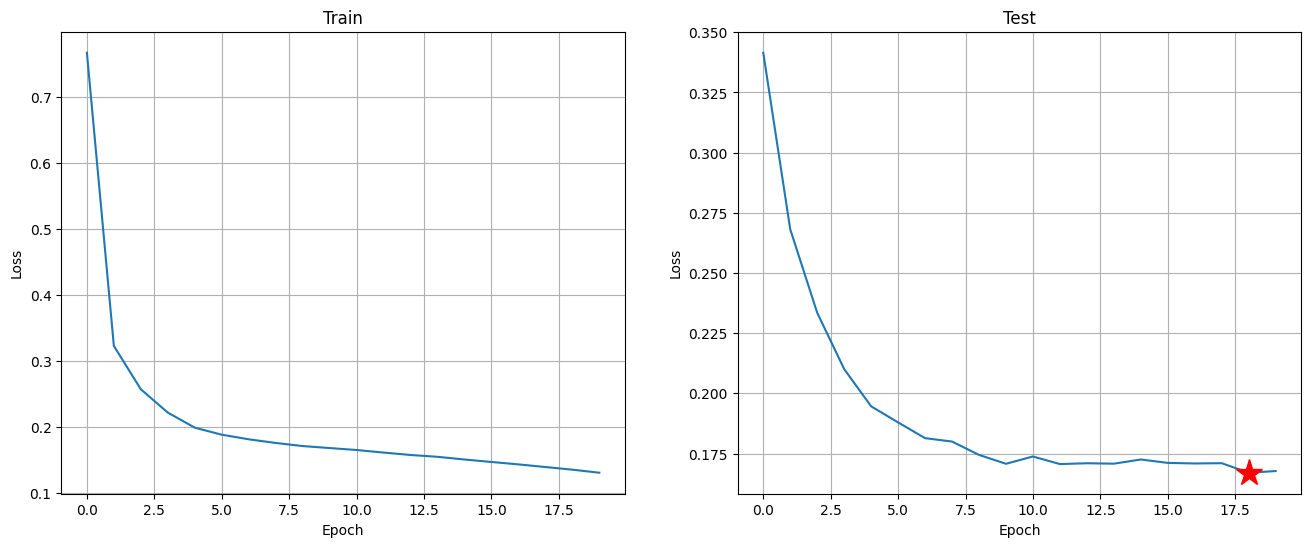

Model is trained. Saving the best model to ../models/rnn_test/.


In [6]:
# train model
train_model(model, trainloader, testloader, save_folder, n_epochs=20,
            verbose=True)

In [7]:
def plot_prediction(ts_past, ts_future, ts_predict, N=5):
    n_forecast = ts_predict.shape[0]
    N0 = N//2*2
    n_lookback = ts_past.shape[0] - N0

    if ts_past.squeeze().ndim == 1:
        plt.figure()
        plt.plot(np.arange(n_lookback+N//2*2), ts_past, color='tab:blue', label='past')
        plt.plot(np.arange(n_lookback+N//2*2,n_lookback+N//2*2+n_forecast), ts_future,
                 color='tab:orange', label='future')
        plt.plot(np.arange(n_lookback+N//2*2,n_lookback+N//2*2+n_forecast), ts_predict,
                 color='green', label='prediction')
        plt.legend()
        plt.xlim([200,403])
        plt.show()
    else:
        plt.figure(figsize=(12,4), layout='constrained')
        for idx_f in range(ts_predict.shape[1]):
            plt.subplot(1,2,1+idx_f)
            plt.plot(np.arange(n_lookback+N//2*2), ts_past[:,idx_f], color='tab:blue', label='past')
            plt.plot(np.arange(n_lookback+N//2*2,n_lookback+N//2*2+n_forecast), ts_future[:,idx_f],
                     color='tab:orange', label='future')
            plt.plot(np.arange(n_lookback+N//2*2,n_lookback+N//2*2+n_forecast), ts_predict[:,idx_f],
                     color='green', label='prediction')
            plt.legend()
            plt.xlim([200,403])
        plt.show()

In [8]:
# predict on single time series
n_test = int(len(ts_data)*0.8)
ts_test = ts_data[n_test:]
print(f"Test length: {len(ts_test)}")

N = 5
idx = 1000
t0 = idx - N//2
t1 = idx + N//2
ts_past = ts_test[t0:t1+n_lookback]
ts_future = ts_test[t1+n_lookback:t1+n_lookback+n_forecast]
print(ts_past.shape, ts_future.shape)

t0 = time.perf_counter()
ts_predict = model.predict_on_series(ts_past, series_class, device='cuda')
t = time.perf_counter() - t0
print(f"Prediction time: {t*1000:.2f} ms")

Test length: 2000
(304, 2) (100, 2)
Prediction time: 2.27 ms


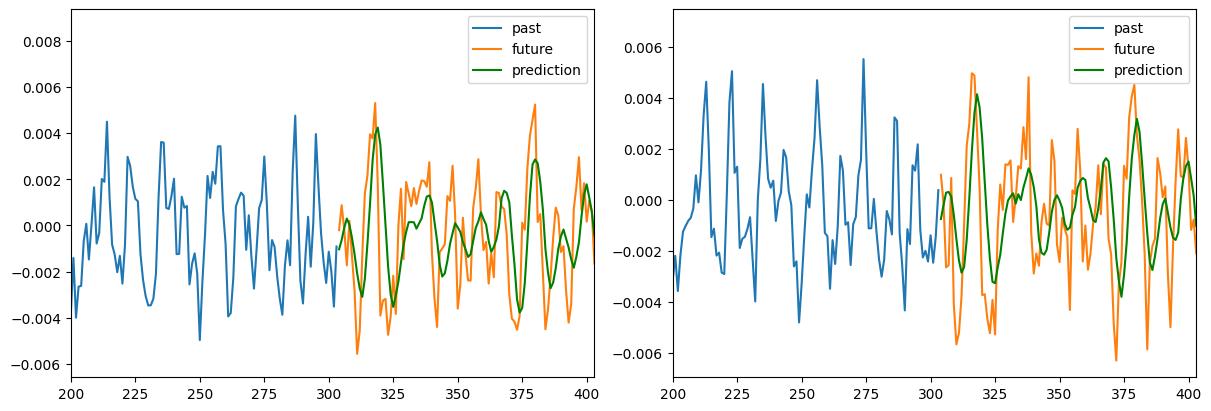

In [9]:
plot_prediction(ts_past, ts_future, ts_predict, N=N)

Prediction time: 2.33 ms


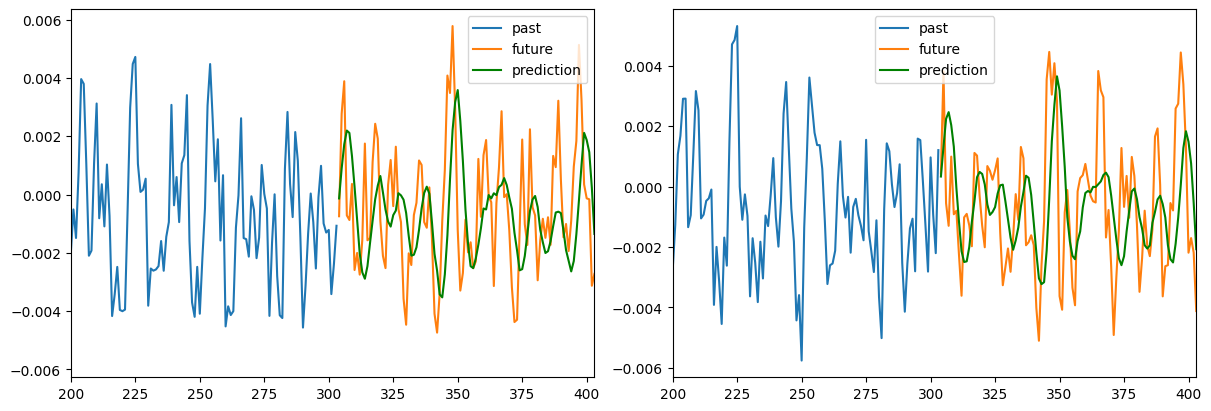

Prediction time: 1.90 ms


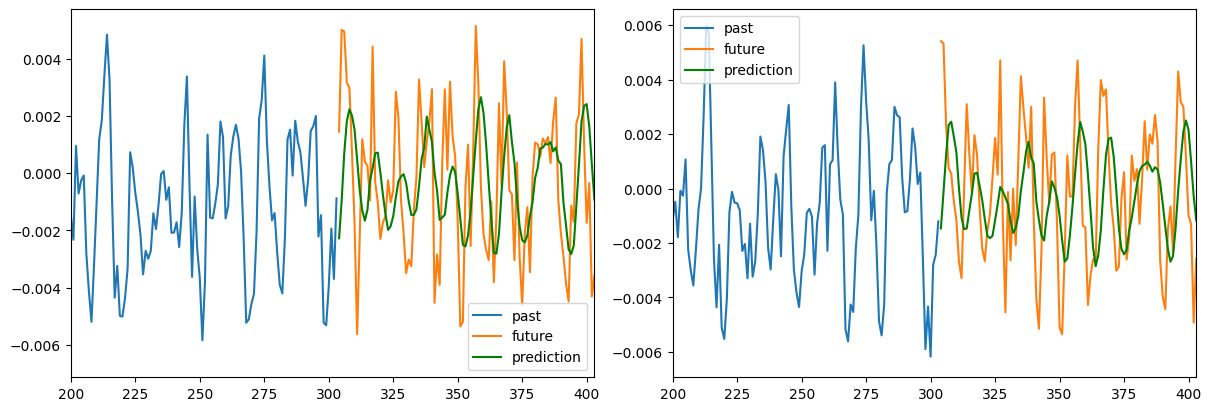

Prediction time: 1.79 ms


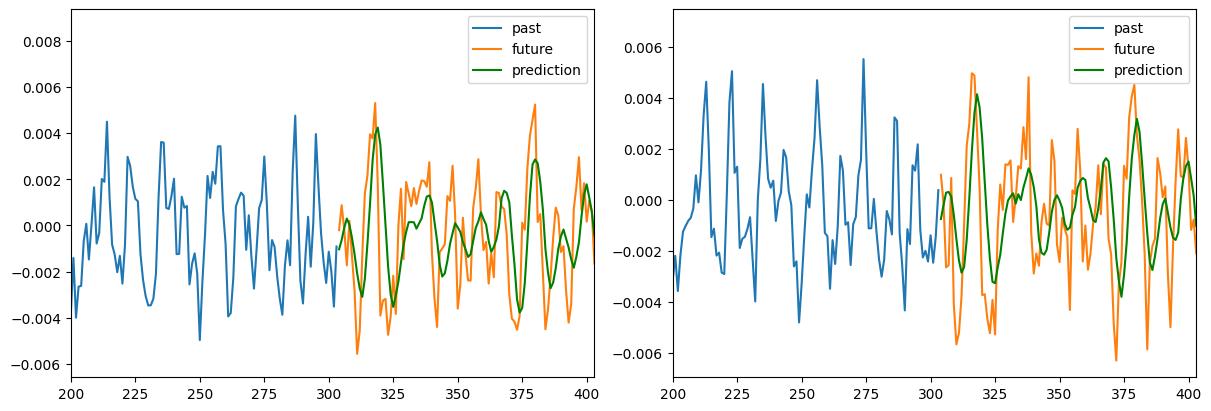

Prediction time: 1.83 ms


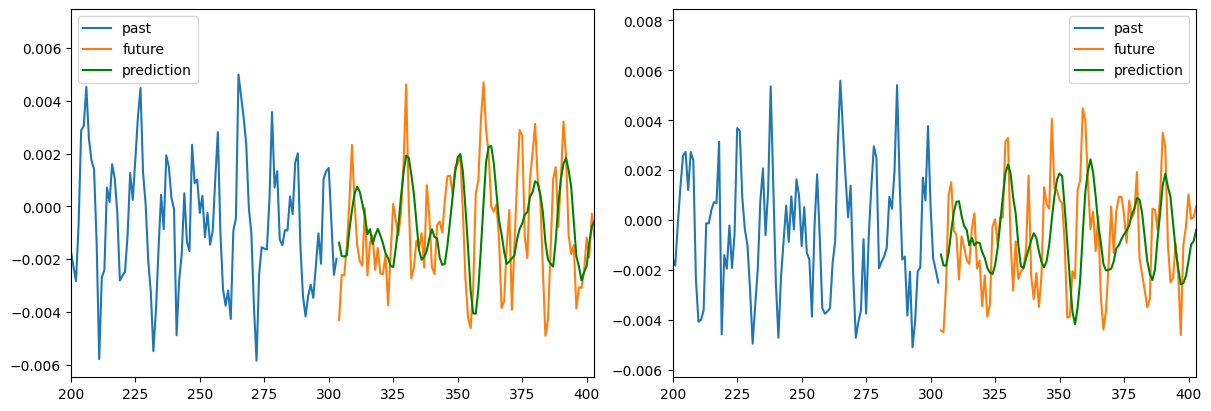

In [10]:
# check out more results

idxs = [100, 500, 1000, 1500]
for idx in idxs:
    t0 = idx - N//2
    t1 = idx + N//2
    ts_past = ts_test[t0:t1+n_lookback]
    ts_future = ts_test[t1+n_lookback:t1+n_lookback+n_forecast]
    
    t0 = time.perf_counter()
    ts_predict = model.predict_on_series(ts_past, series_class, device='cuda')
    t = time.perf_counter() - t0
    print(f"Prediction time: {t*1000:.2f} ms")

    plot_prediction(ts_past, ts_future, ts_predict, N=N)